In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import xgboost as xgb

In [2]:
#load cleaned dataset
df= pd.read_parquet("../data/cleaned_data.parquet")
df.head()

,ffb_1%_oer,import,export,production,end_stock,cpo_futures,usd_myr_rate,brent_oil_futures,soybean_futures,precipitation,...,avg_humidity,lag_1,lag_3,lag_7,rolling_mean_7,rolling_mean_30,rolling_std_7,rolling_std_30,pct_change_1,pct_change_7
0,21.2,81477,1680891,1737461,3002871,2204.0,4.1075,61.65,30.74,20.6,...,88.041667,21.25,20.85,20.60,20.992857,20.533333,0.212972,0.319032,-0.002353,0.029126
1,21.3,81477,1680891,1737461,3002871,2200.0,4.0960,61.89,30.48,47.5,...,90.083333,21.20,21.20,20.75,21.071429,20.576667,0.209875,0.332113,0.004717,0.026506
2,21.3,94278,1324615,1544518,3056929,2200.0,4.0960,62.75,30.21,7.0,...,89.958333,21.30,21.25,20.85,21.135714,20.620000,0.199404,0.339015,0.000000,0.021583
3,21.3,94278,1324615,1544518,3056929,2200.0,4.0960,62.75,30.21,4.7,...,90.083333,21.30,21.20,20.85,21.200000,20.660000,0.160728,0.346261,0.000000,0.021583
4,21.3,94278,1324615,1544518,3056929,2200.0,4.0960,62.75,30.21,13.2,...,89.125000,21.30,21.30,20.85,21.264286,20.690000,0.047559,0.361606,0.000000,0.021583


Data Preparation:

*to change the chronology of data split and rolling/lag features calc. (Must be split dataset first, baru compute rolling/lag and other engineered features)

In [3]:
target_col = "ffb_1%_oer"
raw_features = ["import", "export", "production", "end_stock", 
                "cpo_futures", "usd_myr_rate", "brent_oil_futures", 
                "soybean_futures", "precipitation", "avg_temperature", "avg_humidity"]

engineered_features = ["lag_1","lag_3","lag_7","rolling_mean_7",
                       "rolling_mean_30","rolling_std_7","rolling_std_30",
                       "pct_change_1","pct_change_7"]

engineered_features_lstm = ["lag_1", "rolling_mean_7"]

X = df[raw_features + engineered_features].values
y = df[target_col].values.reshape(-1,1)


#Splitting into train-validate-test dataa
N = len(df)
train_size = int(N * 0.7)   # 70% train
val_size   = int(N * 0.2)  # 20% validation
test_size  = N - train_size - val_size  # 10% test

X_train_raw = X[:train_size]
X_val_raw   = X[train_size:train_size+val_size]
X_test_raw  = X[train_size+val_size:]

y_train_raw = y[:train_size]
y_val_raw   = y[train_size:train_size+val_size]
y_test_raw  = y[train_size+val_size:]


#scale data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_x.fit_transform(X_train_raw)
X_val   = scaler_x.transform(X_val_raw)
X_test  = scaler_x.transform(X_test_raw)

y_train = scaler_y.fit_transform(y_train_raw)
y_val   = scaler_y.transform(y_val_raw)
y_test  = scaler_y.transform(y_test_raw)

Try Forecast Horizon = 14 days:

In [4]:
def create_multi_step_sequences(X, y, lookback, horizon):
    Xs, ys = [], []
    for i in range(lookback, len(X) - horizon + 1):
        Xs.append(X[i - lookback:i])
        ys.append(y[i:i + horizon].ravel())  # collect next horizon steps
    return np.array(Xs), np.array(ys)

forecast_horizon = 14
lookback = 90
X_train_lstm, y_train_lstm = create_multi_step_sequences(X_train, y_train, lookback, forecast_horizon)
X_val_lstm, y_val_lstm     = create_multi_step_sequences(X_val, y_val, lookback, forecast_horizon)
X_test_lstm, y_test_lstm   = create_multi_step_sequences(X_test, y_test, lookback, forecast_horizon)

LSTM Model

In [5]:
from tensorflow.keras import backend as K
import tensorflow as tf
import random
from tensorflow.keras.callbacks import EarlyStopping

#Clear previous model
K.clear_session()

#fix random seeds for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(lookback, X_train.shape[1])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(forecast_horizon)  # output 14 values simultaneously
])

lstm_model.compile(optimizer="adam", loss="mse")

#EarlyStopping Callback
early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 15,
    restore_best_weights=True
)

history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    epochs = 50,
    batch_size = 32,
    callbacks = [early_stop],
    verbose=1
)

y_pred_lstm = lstm_model.predict(X_test_lstm)

# Shape is now (samples, horizon)
y_pred_lstm_inv = scaler_y.inverse_transform(y_pred_lstm.reshape(-1,1)).reshape(y_pred_lstm.shape)
y_test_lstm_inv = scaler_y.inverse_transform(y_test_lstm.reshape(-1,1)).reshape(y_test_lstm.shape)


Epoch 1/50


c:\Users\User\Desktop\test2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0554 - val_loss: 0.0048
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0154 - val_loss: 0.0039
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0105 - val_loss: 0.0047
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0083 - val_loss: 0.0020
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0069 - val_loss: 0.0049
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0062 - val_loss: 0.0026
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0058 - val_loss: 0.0012
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0051 - val_loss: 0.0014
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0045 - val_loss: 0.0019
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0042 - val_loss: 0.0018
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0038 - val_loss: 0.0016
Epoch 12/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0036 - val_l

In [ ]:
#Save the lstm model
lstm_model.save('Backend/models/lstm_model.h5')

XGBoost Model

In [6]:
xgb_models = []
y_preds_xgb = []
xgb_features_idx = [(raw_features + engineered_features).index(f) for f in engineered_features ]

X_train_xgb = X_train[:,xgb_features_idx]
X_val_xgb = X_val[:,xgb_features_idx]
X_test_xgb = X_test[:,xgb_features_idx]

params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "eta": 0.1,
    "max_depth": 5
}


for step in range(forecast_horizon):
    # target is shifted for each horizon step
    y_train_step = y_train[lookback + step: len(y_train) - forecast_horizon + step + 1]
    y_val_step   = y_val[lookback + step: len(y_val) - forecast_horizon + step + 1]
    y_test_step  = y_test[lookback + step: len(y_test) - forecast_horizon + step + 1]
    
    dtrain = xgb.DMatrix(X_train_xgb[lookback:len(y_train_step)+lookback], label=y_train_step)
    dval   = xgb.DMatrix(X_val_xgb[lookback:len(y_val_step)+lookback], label=y_val_step)
    dtest  = xgb.DMatrix(X_test_xgb[lookback:len(y_test_step)+lookback])

    model_step = xgb.train(
        params,
        dtrain,
        num_boost_round=500,
        evals=[(dtrain, "train"), (dval, "val")],
        early_stopping_rounds=20,
        verbose_eval=True
    )
    xgb_models.append(model_step)
    y_preds_xgb.append(model_step.predict(dtest))

y_pred_xgb = np.column_stack(y_preds_xgb)  # shape: (samples, horizon)
y_pred_xgb_inv = scaler_y.inverse_transform(y_pred_xgb)

[0]	train-rmse:0.19130	val-rmse:0.03408
[1]	train-rmse:0.17263	val-rmse:0.03078
[2]	train-rmse:0.15577	val-rmse:0.02776
[3]	train-rmse:0.14058	val-rmse:0.02501
[4]	train-rmse:0.12689	val-rmse:0.02251
[5]	train-rmse:0.11456	val-rmse:0.02045
[6]	train-rmse:0.10344	val-rmse:0.01863
[7]	train-rmse:0.09341	val-rmse:0.01699
[8]	train-rmse:0.08438	val-rmse:0.01542
[9]	train-rmse:0.07624	val-rmse:0.01402
[10]	train-rmse:0.06890	val-rmse:0.01257
[11]	train-rmse:0.06229	val-rmse:0.01154
[12]	train-rmse:0.05633	val-rmse:0.01062
[13]	train-rmse:0.05096	val-rmse:0.00965
[14]	train-rmse:0.04611	val-rmse:0.00876
[15]	train-rmse:0.04175	val-rmse:0.00811
[16]	train-rmse:0.03782	val-rmse:0.00753
[17]	train-rmse:0.03428	val-rmse:0.00695
[18]	train-rmse:0.03109	val-rmse:0.00644
[19]	train-rmse:0.02822	val-rmse:0.00594
[20]	train-rmse:0.02562	val-rmse:0.00557
[21]	train-rmse:0.02329	val-rmse:0.00512
[22]	train-rmse:0.02118	val-rmse:0.00482
[23]	train-rmse:0.01928	val-rmse:0.00459
[24]	train-rmse:0.01757	va

In [ ]:
#Save XGBoost Models
import os

os.makedirs('models/xgb_models', exist_ok=True)

for i, model in enumerate(xgb_models):
    model.save_model(f'models/xgb_models/xgb_model_step_{i+1}.json')

Option 1: Hybrid fusion using error-based weighting:

In [8]:
# --- 1. Get validation predictions ---
# LSTM validation prediction
y_pred_val_lstm = lstm_model.predict(X_val_lstm)
y_pred_val_lstm_inv = scaler_y.inverse_transform(
    y_pred_val_lstm.reshape(-1,1)
).reshape(y_pred_val_lstm.shape)

# XGBoost validation prediction
y_preds_val_xgb = []
for step, model_step in enumerate(xgb_models):
    dval = xgb.DMatrix(X_val_xgb[lookback: len(y_val_lstm) + lookback])
    y_preds_val_xgb.append(model_step.predict(dval))

y_pred_val_xgb = np.column_stack(y_preds_val_xgb)
y_pred_val_xgb_inv = scaler_y.inverse_transform(y_pred_val_xgb)

# --- 2. Compute validation errors per horizon ---
val_errors_lstm = [
    root_mean_squared_error(y_val_lstm[:, h], y_pred_val_lstm_inv[:, h])
    for h in range(forecast_horizon)
]
val_errors_xgb = [
    root_mean_squared_error(y_val_lstm[:, h], y_pred_val_xgb_inv[:, h])
    for h in range(forecast_horizon)
]

# --- 3. Convert errors into weights (lower error = higher weight) ---
val_errors_lstm = np.array(val_errors_lstm)
val_errors_xgb  = np.array(val_errors_xgb)

weights_lstm = 1 / val_errors_lstm
weights_xgb  = 1 / val_errors_xgb
weights_sum  = weights_lstm + weights_xgb
weights_lstm /= weights_sum
weights_xgb  /= weights_sum

print("Validation Weights (per horizon):")
for h in range(forecast_horizon):
    print(f"H{h+1}: LSTM={weights_lstm[h]:.2f}, XGB={weights_xgb[h]:.2f}")

# --- 4. Apply weights on test predictions ---
y_pred_hybrid_inv = weights_lstm * y_pred_lstm_inv + weights_xgb * y_pred_xgb_inv

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Validation Weights (per horizon):
H1: LSTM=0.50, XGB=0.50
H2: LSTM=0.50, XGB=0.50
H3: LSTM=0.50, XGB=0.50
H4: LSTM=0.50, XGB=0.50
H5: LSTM=0.50, XGB=0.50
H6: LSTM=0.50, XGB=0.50
H7: LSTM=0.50, XGB=0.50
H8: LSTM=0.50, XGB=0.50
H9: LSTM=0.50, XGB=0.50
H10: LSTM=0.51, XGB=0.49
H11: LSTM=0.51, XGB=0.49
H12: LSTM=0.51, XGB=0.49
H13: LSTM=0.51, XGB=0.49
H14: LSTM=0.51, XGB=0.49


Option 2: Ensemble fusion (meta learner stacking) to combine lstm and xgboost output:

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor

# Prepare validation-level stacking features
# Each has shape (n_val_samples, horizon)
lstm_val_preds = y_pred_val_lstm_inv  # shape (n_samples, horizon)
xgb_val_preds  = y_pred_val_xgb_inv
y_val_lstm_inv = scaler_y.inverse_transform(y_val_lstm.reshape(-1,1)).reshape(y_val_lstm.shape)

# Stack as columns per horizon: we can create features shape (n_samples, 2*horizon) or (n_samples, horizon, 2) with flattening
X_stack_val = np.concatenate([lstm_val_preds, xgb_val_preds], axis=1)  # (n, 2*h)
y_stack_val = y_val_lstm_inv  # true values on validation (shape (n, horizon))

# Train a multioutput Ridge to map stacked preds -> true y
# Simpler: train a multioutput ridge per horizon via MultiOutputRegressor
meta = MultiOutputRegressor(Ridge(alpha=1.0))
meta.fit(X_stack_val, y_stack_val)

# To predict on test:
lstm_test_preds = y_pred_lstm_inv
xgb_test_preds  = y_pred_xgb_inv
X_stack_test = np.concatenate([lstm_test_preds, xgb_test_preds], axis=1)
y_pred_meta = meta.predict(X_stack_test)  # shape (n_test, horizon)

# Produce the 14-day forecast
final_forecast = y_pred_meta[-1]
print("Final hybrid forecast for the next 14 days:", final_forecast)

# Evaluate vs previous hybrid:
for h in range(forecast_horizon):
    rmse_meta = root_mean_squared_error(y_test_lstm_inv[:, h], y_pred_meta[:, h])
    rmse_weighted = root_mean_squared_error(y_test_lstm_inv[:, h], y_pred_hybrid_inv[:, h])
    print(f"H{h+1}: RMSE_meta={rmse_meta:.4f} RMSE_weighted={rmse_weighted:.4f}")


H1: RMSE_meta=0.7259 RMSE_weighted=1.5071
H2: RMSE_meta=0.7061 RMSE_weighted=1.1867
H3: RMSE_meta=0.7734 RMSE_weighted=1.7079
H4: RMSE_meta=0.8516 RMSE_weighted=1.7032
H5: RMSE_meta=0.9606 RMSE_weighted=1.7079
H6: RMSE_meta=1.1310 RMSE_weighted=1.5598
H7: RMSE_meta=1.3563 RMSE_weighted=1.7925
H8: RMSE_meta=1.4588 RMSE_weighted=1.7870
H9: RMSE_meta=1.6027 RMSE_weighted=1.9532
H10: RMSE_meta=1.7177 RMSE_weighted=2.1328
H11: RMSE_meta=1.8562 RMSE_weighted=2.1832
H12: RMSE_meta=1.8979 RMSE_weighted=2.4181
H13: RMSE_meta=2.0654 RMSE_weighted=2.8556
H14: RMSE_meta=2.3522 RMSE_weighted=2.5317


Performance metric measurement:

In [ ]:
for h in range(forecast_horizon):
    rmse = root_mean_squared_error(y_test_lstm_inv[:, h], y_pred_meta[:, h])
    mae  = mean_absolute_error(y_test_lstm_inv[:, h], y_pred_meta[:, h])
    mape = mean_absolute_percentage_error(y_test_lstm_inv[:, h], y_pred_meta[:, h])
    r2   = r2_score(y_test_lstm_inv[:, h], y_pred_meta[:, h])
    
    print(f"Horizon {h+1}: RMSE={rmse:.4f}, MAE={mae:.4f}, MAPE={mape:.2%}, R²={r2:.2%}")

Horizon 1: RMSE=1.5071, MAE=1.2362, MAPE=2.63%, R²=80.86%
Horizon 2: RMSE=1.1867, MAE=0.9622, MAPE=2.06%, R²=88.43%
Horizon 3: RMSE=1.7079, MAE=1.4003, MAPE=3.00%, R²=76.57%
Horizon 4: RMSE=1.7032, MAE=1.3975, MAPE=3.00%, R²=77.23%
Horizon 5: RMSE=1.7079, MAE=1.3888, MAPE=2.99%, R²=77.54%
Horizon 6: RMSE=1.5598, MAE=1.2780, MAPE=2.76%, R²=81.60%
Horizon 7: RMSE=1.7925, MAE=1.4369, MAPE=3.10%, R²=76.12%
Horizon 8: RMSE=1.7870, MAE=1.4475, MAPE=3.14%, R²=76.75%
Horizon 9: RMSE=1.9532, MAE=1.5911, MAPE=3.46%, R²=72.92%
Horizon 10: RMSE=2.1328, MAE=1.7124, MAPE=3.72%, R²=68.61%
Horizon 11: RMSE=2.1832, MAE=1.7143, MAPE=3.71%, R²=67.86%
Horizon 12: RMSE=2.4181, MAE=1.8797, MAPE=4.08%, R²=61.29%
Horizon 13: RMSE=2.8556, MAE=2.1224, MAPE=4.55%, R²=47.07%
Horizon 14: RMSE=2.5317, MAE=1.9379, MAPE=4.21%, R²=59.18%


Recommendation Engine:

In [ ]:
ffb = df['ffb_1%_oer']
returns = ffb.pct_change().dropna() * 100

avg_daily_change = returns.mean()
volatility = returns.std()

forecast = y_pred_meta[-1]

def recommendation_engine(current_price, forecast, volatility, k=0.8):
    threshold = k * volatility

    short_term = np.mean(forecast[:3])
    long_term = np.mean(forecast[7:14])
    avg_forecast = np.mean(forecast)

    short_change = (short_term - current_price) / current_price * 100
    long_change = (long_term - current_price) / current_price * 100
    overall_change = (avg_forecast - current_price) / current_price * 100

    if short_change < -threshold and long_change < -threshold:
        action = "SELL immediately"
    elif short_change < - threshold and long_change > threshold:
        action = "HOLD harvest (price will rebound later)"
    elif short_change > threshold and long_change <- threshold:
        action = "SELL some and HOLD some (uncertain trend)"
    elif abs(overall_change) < threshold:
        action = "NEUTRAL (The market is stable)"
    else:
        action = "WAIT and monitor"
    
    return {
        "short_term_change": short_change,
        "long_term_change": long_change,
        "overall_change": overall_change,
        "threshold": threshold,
        "recommendation": action
    } 


In [ ]:
current_price = y_test_lstm_inv[-1, 0] 
forecast = y_pred_meta[-1]

recommendation = recommendation_engine(current_price, forecast, volatility, k=0.8)

print("\n=== Final Forecast and Recommendation ===")
print("Short-term change: {:.2f}%".format(recommendation["short_term_change"]))
print("long-term change: {:.2f}%".format(recommendation["long_term_change"]))
print("overall change: {:.2f}%".format(recommendation["overall_change"]))
print("Volatility threshold: {:.2f}%".format(recommendation["threshold"]))
print("Recommendation: ",recommendation["recommendation"])
print("Forecasted price for the next 14 days: ", forecast)



Short-term change: 0.33%
long-term change: 1.53%
overall change: 1.22%
Volatility threshold: 1.03%
Recommendation:  WAIT and monitor
Forecasted price for the next 14 days:  [38.39776011 38.51949988 38.51337963 38.76409042 38.69399367 38.87481441
 39.11891931 39.16059847 39.14795866 39.14485919 38.86741401 38.98305421
 38.70695854 38.55788782]


Aggregrate Metrics accross horizon:

In [12]:
#compute per-horizon metrics then aggregrate
rmse_per_h = np.array([root_mean_squared_error(y_test_lstm_inv[:,h], y_pred_hybrid_inv[:,h]) 
                       for h in range(forecast_horizon)])
mae_per_h = np.array([mean_absolute_error(y_test_lstm_inv[:,h], y_pred_hybrid_inv[:,h]) 
                       for h in range(forecast_horizon)])
mape_per_h = np.array([mean_absolute_percentage_error(y_test_lstm_inv[:,h], y_pred_hybrid_inv[:,h]) 
                       for h in range(forecast_horizon)])
r2_per_h = np.array([r2_score(y_test_lstm_inv[:,h], y_pred_hybrid_inv[:,h]) 
                       for h in range(forecast_horizon)])

#aggregate summaries
agg_metrics = {
    "rmse_mean": rmse_per_h.mean(),
    "rmse_std": rmse_per_h.std(),
    "mae_mean": mae_per_h.mean(),
    "mape_mean": mape_per_h.mean(),
    "r2_mean": r2_per_h.mean(),
}

print("Aggregate metrics:", agg_metrics)

Aggregate metrics: {'rmse_mean': np.float64(1.930478866533779), 'rmse_std': np.float64(0.4326451317197257), 'mae_mean': np.float64(1.5360880124281497), 'mape_mean': np.float64(0.03313954486392234), 'r2_mean': np.float64(0.7228757771959617)}


SHAP for explainability:

In [13]:
import shap 

explainer = shap.TreeExplainer(xgb_models[0])

sample_idx = -1
sample = X_test_xgb[lookback + sample_idx: lookback + sample_idx + 1]

shap_vals = explainer.shap_values(sample)
feature_names = [raw_features + engineered_features][0]
shap_contribs = list(zip(feature_names, shap_vals.ravel()))
shap_contribs_sorted = sorted(shap_contribs, key=lambda x: abs(x[1]), reverse=True)

top3 = shap_contribs_sorted[:3]
print("Top 3 drivers for XGB horizon-1 prediction:", top3)

c:\Users\User\Desktop\test2\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Top 3 drivers for XGB horizon-1 prediction: [('import', np.float32(0.11330938)), ('end_stock', np.float32(0.019611077)), ('export', np.float32(0.016157694))]


Visualizations:

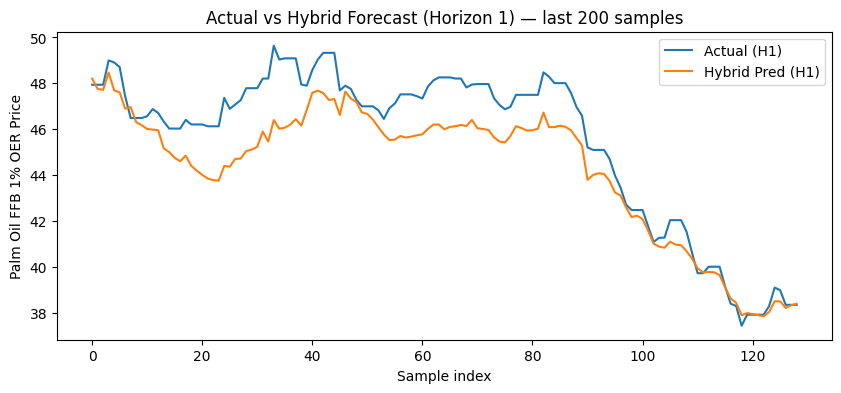

In [20]:
import matplotlib.pyplot as plt

# pick last 200 points from test ground truth and matching predictions (flatten horizon-1 or aggregated)
n = 200
actual = y_test_lstm_inv[-n:, 0]  # horizon-1 actuals
pred_hybrid_h1 = y_pred_hybrid_inv[-n:, 0]

plt.figure(figsize=(10,4))
plt.plot(actual, label="Actual (H1)")
plt.plot(pred_hybrid_h1, label="Hybrid Pred (H1)")
plt.legend()
plt.title("Actual vs Hybrid Forecast (Horizon 1) — last 200 samples")
plt.xlabel("Sample index")
plt.ylabel("Palm Oil FFB 1% OER Price")
plt.show()


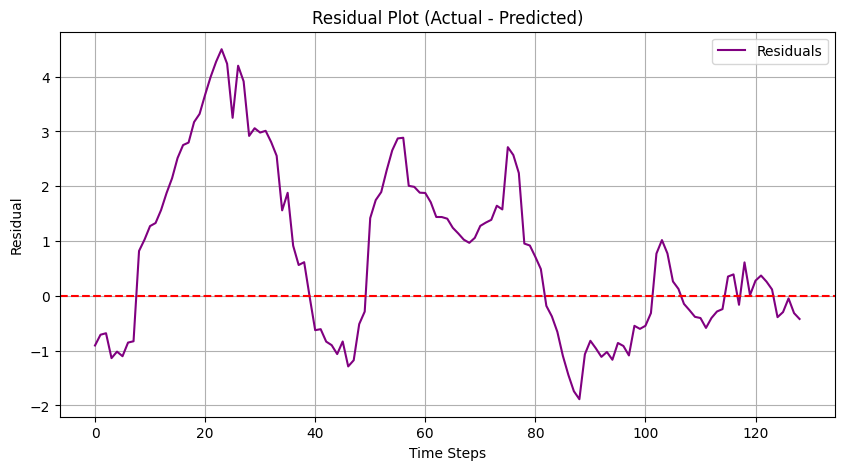

In [ ]:
#Residual Plot
avg_actual = np.mean(y_test_lstm_inv, axis=1)
avg_pred = np.mean(y_pred_hybrid_inv, axis=1)

residuals = avg_actual - avg_pred

plt.figure(figsize=(10, 5))
plt.plot(residuals, label='Residuals', color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot (Actual - Predicted)")
plt.xlabel("Time Steps")
plt.ylabel("Residual")
plt.legend()
plt.grid(True)
plt.show()

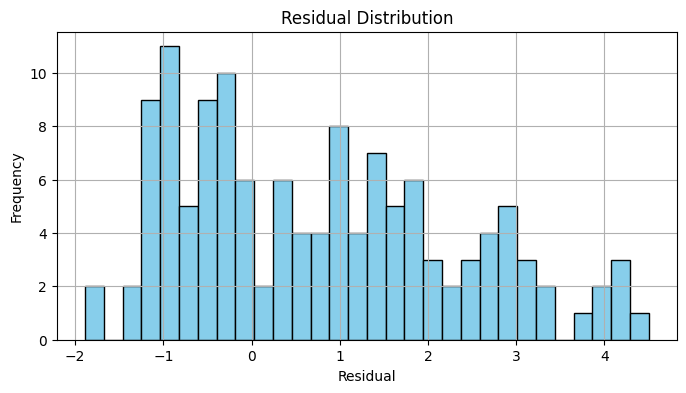

In [16]:
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

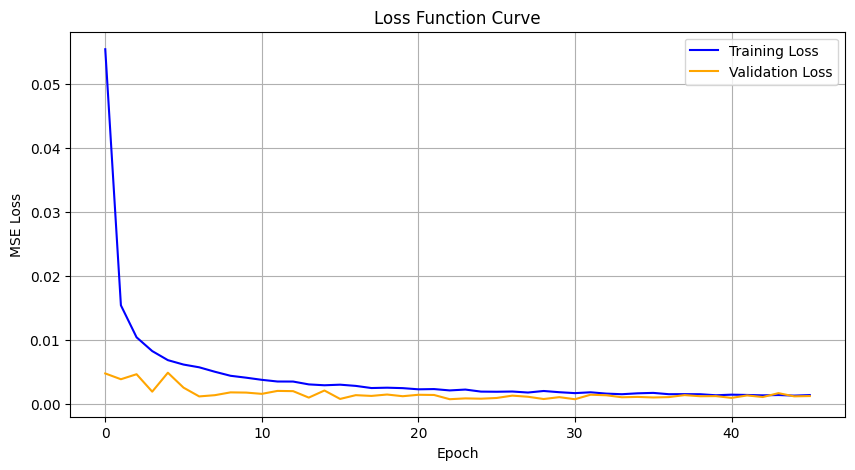

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title("Loss Function Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

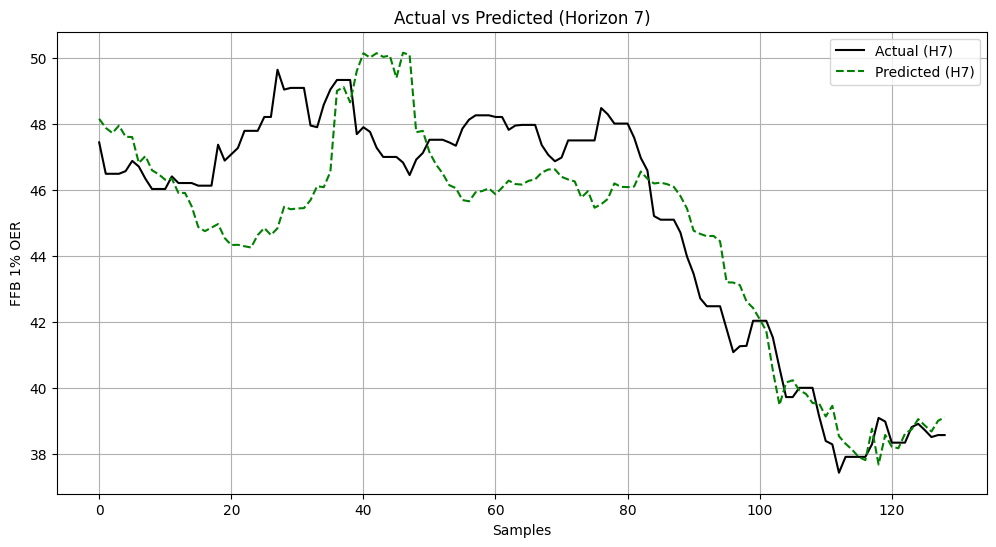

In [18]:
horizon_to_plot = 6  # index 6 = 7th day ahead
plt.figure(figsize=(12, 6))
plt.plot(y_test_lstm_inv[:, horizon_to_plot], label=f'Actual (H{horizon_to_plot+1})', color='black')
plt.plot(y_pred_hybrid_inv[:, horizon_to_plot], label=f'Predicted (H{horizon_to_plot+1})', color='green', linestyle='--')
plt.title(f"Actual vs Predicted (Horizon {horizon_to_plot+1})")
plt.xlabel("Samples")
plt.ylabel("FFB 1% OER")
plt.legend()
plt.grid(True)
plt.show()

Calibrate k (threshold multiplier) on validation set (using grid search):

In [ ]:
def directional_accuracy(recommendation_eng, X_current_prices, y_true_future, forecast_fn, volatility_series, k):
    